In [ ]:
import pandas as pd
import numpy as np
import queue
import requests
import json
import asyncio
import websockets
import nest_asyncio
import gzip
import time
import threading
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator

In [65]:
async def ws_handler(id, url, msg, collective_data, start_event):
    print("ready to start")
    start_event.wait()
    duration = 10  # in secs
    print("start !")
    time.sleep(1)  # stop for main thread to ready
    
    start_time = time.time()
    while time.time() - start_time <= duration :
        try :
            async with websockets.connect(url) as websocket:
                # Send a message
                await websocket.send(json.dumps(msg))
                print(f"Sent: {msg}")
                best_bid = 0
                best_ask = 0

                while time.time() - start_time <= duration :
                    # Receive a response
                    recv = await websocket.recv()
                    
                    if isinstance(recv, bytes) :
                        # for binary data
                        decompress_data = gzip.decompress(recv)
                        response = json.loads(decompress_data.decode("utf-8"))
                        
                        try :
                            ts = time.time_ns()
                            new_data =  {"bids" : float(response["tick"]["bids"][0][0]), "asks" : float(response["tick"]["asks"][0][0])}
                            collective_data.put(new_data)
                            #collective_data.loc[ts] = {"bids" : float(response["tick"]["bids"][0][0]), "asks" : float(response["tick"]["asks"][0][0])}

                        except websockets.exceptions.ConnectionClosedError as e:
                            print(f"Connection failed to connect: {e}")   
                            raise e 
                            
                            
                        except Exception as e :
                            print(f"error {e} at htx")
                        
                            if "ping" in response.keys():
                                # Extract the ping timestamp
                                ping_timestamp = response["ping"]
                                
                                # Create and send the pong response
                                pong_message = {"pong": ping_timestamp}
                                await websocket.send(json.dumps(pong_message))
                                print(f"Sent pong msg: {pong_message}")
                            

                    else :
                        # other exchanges
                        response = json.loads(recv)
                        # print(f"Received at {id}")
                        # print(response) 
                        
                        try :
                            ts = time.time_ns()
                            if id == "gateio" :
                                new_data =  {"bids" : float(response["result"]["b"]), "asks" : float(response["result"]["a"])}
                                collective_data.put(new_data)
                                #collective_data.loc[ts] = {"bids" : float(response["result"]["b"]), "asks" : float(response["result"]["a"])}
                            elif id == "bybit":
                                
                                
                                try :
                                    best_ask =  float(response["data"]['a'][0][0])
                                    best_bid =  float(response["data"]['b'][0][0])
                                    #collective_data.loc[ts] = {"bids" : float(best_bid), "asks" : float(best_ask)}
                                    new_data = {"bids" : best_bid, "asks" : best_ask}
                                    collective_data.put(new_data)
                                except IndexError as e :
                                    if response["data"]['b'] != []:
                                        best_bid = response["data"]['b'][0][0]
                                    if  response["data"]['a'] != []:
                                        best_ask = response["data"]['a'][0][0]
                                    
                                    new_data = {"bids" : float(best_bid), "asks" : float(best_ask)}
                                    collective_data.put(new_data)
                                    #collective_data.loc[ts] = {"bids" : float(best_bid), "asks" : float(best_ask)}
                                    
                            elif id == "bitget":
                                
                                new_data =  {"bids" : float(response["data"][0]['bids'][0][0]), "asks" :  float(response["data"][0]['asks'][0][0])}
                                collective_data.put(new_data)
                                #collective_data.loc[ts] = {"bids" : float(response["data"][0]['bids'][0][0]), "asks" :  float(response["data"][0]['asks'][0][0])}

                        except websockets.exceptions.ConnectionClosedError as e:
                            print(f"Connection failed to start: {e}")   
                            raise e 

                        except Exception as e :
                            print(f"error {e} at {id} and pass ")
                                    
        except websockets.exceptions.ConnectionClosedError as e:
            print(f"reconnect for {id}")   
            
                
    print(f"{id} finish")
    return

def send_websocket_request(thread_id, ws_url, message, df, start_event):
    asyncio.run(ws_handler(thread_id, ws_url, message, df, start_event))


build WS connection for each exchange

In [66]:
# run for 5 mins 
# threading
nest_asyncio.apply()

start_event = threading.Event()
ts = time.time_ns()
target_currency = "BTC"
base_currency = "USDT"
threads = []
ids = ["bitget", "htx", "gateio", "bybit"]
urls = [ "wss://ws.bitget.com/v2/ws/public", 
         "wss://api.hbdm.com/linear-swap-ws",
         "wss://fx-ws.gateio.ws/v4/ws/usdt",
         "wss://stream.bybit.com/v5/public/linear"
        ] 
msgs = [{"op" :"subscribe", "args" : [ {"instType" : f"{base_currency}-FUTURES", "channel" : "books1", "instId" : f"{target_currency}{base_currency}"}]}, 
        {"sub" :f"market.{target_currency}-{base_currency}.depth.step0", "id" : "test0"},
        {"time" : ts, "channel" : "futures.book_ticker", "event" : "subscribe", "payload" : [f"{target_currency}_{base_currency}"]},
        {"op" :"subscribe", "args" : [f"orderbook.1.{target_currency}{base_currency}"],}
        ] 
dfs = [pd.DataFrame(columns=["local_ts", "bids", "asks"]) for _ in range(4)] # data storage 
queues_= []  # cross thread sharing queue 
# worker threads to collecting data
for i in range(4):
    #df = pd.DataFrame(columns=["time", "bids", "asks"]).set_index("time")
    q = queue.Queue()
    queues_.append(q)
    thread = threading.Thread(target=send_websocket_request, args=(ids[i], urls[i], msgs[i], q, start_event))
    threads.append(thread)
    thread.start()
    
print("All threads are ready. Starting in 2 seconds...")
#time.sleep(2)  # Optional delay before starting
start_event.set()  # Signal threads to start

# main thread to collecting data
try :
    prod_data_queues = [queue.Queue() for _ in range(4)]  # to store data from worker thread
    cache_data = [ 0 for _ in range(4) ]  # to cache data for each exchange 
    start_time = time.time()
    duration = 10

    while time.time() - start_time <= duration:
        time.sleep(0.01)  # collecting peroid 
        current_time = time.time_ns()
        for worker_q, storage_q, cache in zip(queues_, prod_data_queues, cache_data):
            if not worker_q.empty() : 
                # not empty queue in worker thread
                curr = worker_q.get()
                curr["local_ts"] = current_time
                print(curr)
                storage_q.put(curr)
                # update cache
                cache = curr
              
                
            else :
                # empty worker queue
                if cache != 0  :
                    # put in previous data
                    storage_q.put(cache)
                else:
                    # put dummy data 
                    storage_q.put({"bids" : 0.0, "asks" :  0.0, "local_ts" : current_time})


except KeyboardInterrupt:
    print("stop by user")
except Exception as e :
    print("unexpected error")
    raise e
    

for thread in threads:
    thread.join()

print("All threads have finished.")

ready to start
ready to start
ready to start
All threads are ready. Starting in 2 seconds...
start !
start !
start !
ready to start
start !
Sent: {'time': 1733144747838740547, 'channel': 'futures.book_ticker', 'event': 'subscribe', 'payload': ['BTC_USDT']}
Sent: {'sub': 'market.BTC-USDT.depth.step0', 'id': 'test0'}
Sent: {'op': 'subscribe', 'args': ['orderbook.1.BTCUSDT']}
error 'b' at gateio and pass 
error 'tick' at htx
{'bids': 95119.2, 'asks': 95119.3, 'local_ts': 1733144749114647626}
error 'data' at bybit and pass 
{'bids': 95079.9, 'asks': 95080.0, 'local_ts': 1733144749124937766}
{'bids': 95079.9, 'asks': 95080.0, 'local_ts': 1733144749135234579}
{'bids': 95079.9, 'asks': 95080.0, 'local_ts': 1733144749145592845}
Sent: {'op': 'subscribe', 'args': [{'instType': 'USDT-FUTURES', 'channel': 'books1', 'instId': 'BTCUSDT'}]}
{'bids': 95079.9, 'asks': 95080.0, 'local_ts': 1733144749166176518}
{'bids': 95119.2, 'asks': 95119.3, 'local_ts': 1733144749176493637}
error 'data' at bitget and

In [67]:
for id, q in zip(ids, prod_data_queues):
    print(id)
    print(q.qsize())
for i in range(4):
    for j in range(prod_data_queues[i].qsize()) :
        curr = prod_data_queues[i].get()     
        dfs[i] = dfs[i].append(curr, ignore_index=True)
    
    dfs[i] = dfs[i].set_index("local_ts")
    print(dfs[i].tail(10))
    print("next")


bitget
973
htx
973
gateio
973
bybit
973
                 bids     asks
local_ts                      
1.733145e+18      0.0      0.0
1.733145e+18      0.0      0.0
1.733145e+18      0.0      0.0
1.733145e+18      0.0      0.0
1.733145e+18      0.0      0.0
1.733145e+18      0.0      0.0
1.733145e+18      0.0      0.0
1.733145e+18      0.0      0.0
1.733145e+18  95048.7  95048.8
1.733145e+18      0.0      0.0
next
                 bids     asks
local_ts                      
1.733145e+18      0.0      0.0
1.733145e+18  95078.3  95079.5
1.733145e+18      0.0      0.0
1.733145e+18      0.0      0.0
1.733145e+18      0.0      0.0
1.733145e+18      0.0      0.0
1.733145e+18      0.0      0.0
1.733145e+18      0.0      0.0
1.733145e+18      0.0      0.0
1.733145e+18      0.0      0.0
next
                 bids     asks
local_ts                      
1.733145e+18      0.0      0.0
1.733145e+18      0.0      0.0
1.733145e+18      0.0      0.0
1.733145e+18  95043.7  95043.8
1.733145e+18  95043.

In [45]:
# check data
for id, q in zip(ids, queues_):
    print(id)
    print(q.qsize())

for i in range(4):
    for j in range(queues_[i].qsize()) :
        curr = queues_[i].get()     
        dfs[i] = dfs[i].append(curr, ignore_index=True)
    
    dfs[i] = dfs[i].set_index("local_ts")
    print(dfs[i].tail(10))
    print("next")


bitget
22832
htx
35998
gateio
62793
bybit
88497
                 bids     asks
local_ts                      
1.733085e+18  96980.8  96981.1
1.733085e+18  96980.8  96981.1
1.733085e+18  96980.8  96981.1
1.733085e+18  96970.0  96970.1
1.733085e+18  96970.0  96970.2
1.733085e+18  96970.0  96970.1
1.733085e+18  96970.0  96970.1
1.733085e+18  96970.0  96970.1
1.733085e+18  96970.0  96970.1
1.733085e+18  96970.0  96970.1
next
                 bids     asks
local_ts                      
1.733085e+18  96913.5  96913.6
1.733085e+18  96913.5  96913.6
1.733085e+18  96913.5  96913.6
1.733085e+18  96913.5  96913.6
1.733085e+18  96913.5  96913.6
1.733085e+18  96913.5  96913.6
1.733085e+18  96913.5  96913.6
1.733085e+18  96913.5  96913.6
1.733085e+18  96913.5  96913.6
1.733085e+18  96913.5  96913.6
next
                 bids     asks
local_ts                      
1.733085e+18  96894.8  96894.9
1.733085e+18  96894.8  96894.9
1.733085e+18  96894.8  96894.9
1.733085e+18  96894.8  96894.9
1.733085e+18

In [46]:
start_ts = []
end_ts = []
for i in range(4):
    start_ts.append(dfs[i].index[0])
    end_ts.append(dfs[i].index[-1])
first_ts = min(start_ts)
last_ts = max(end_ts)
print(first_ts, last_ts)

print((last_ts - first_ts)/ 10000)


1.7330816527372966e+18 1.7330852526034537e+18
359986615.7056


bitget htx
22832


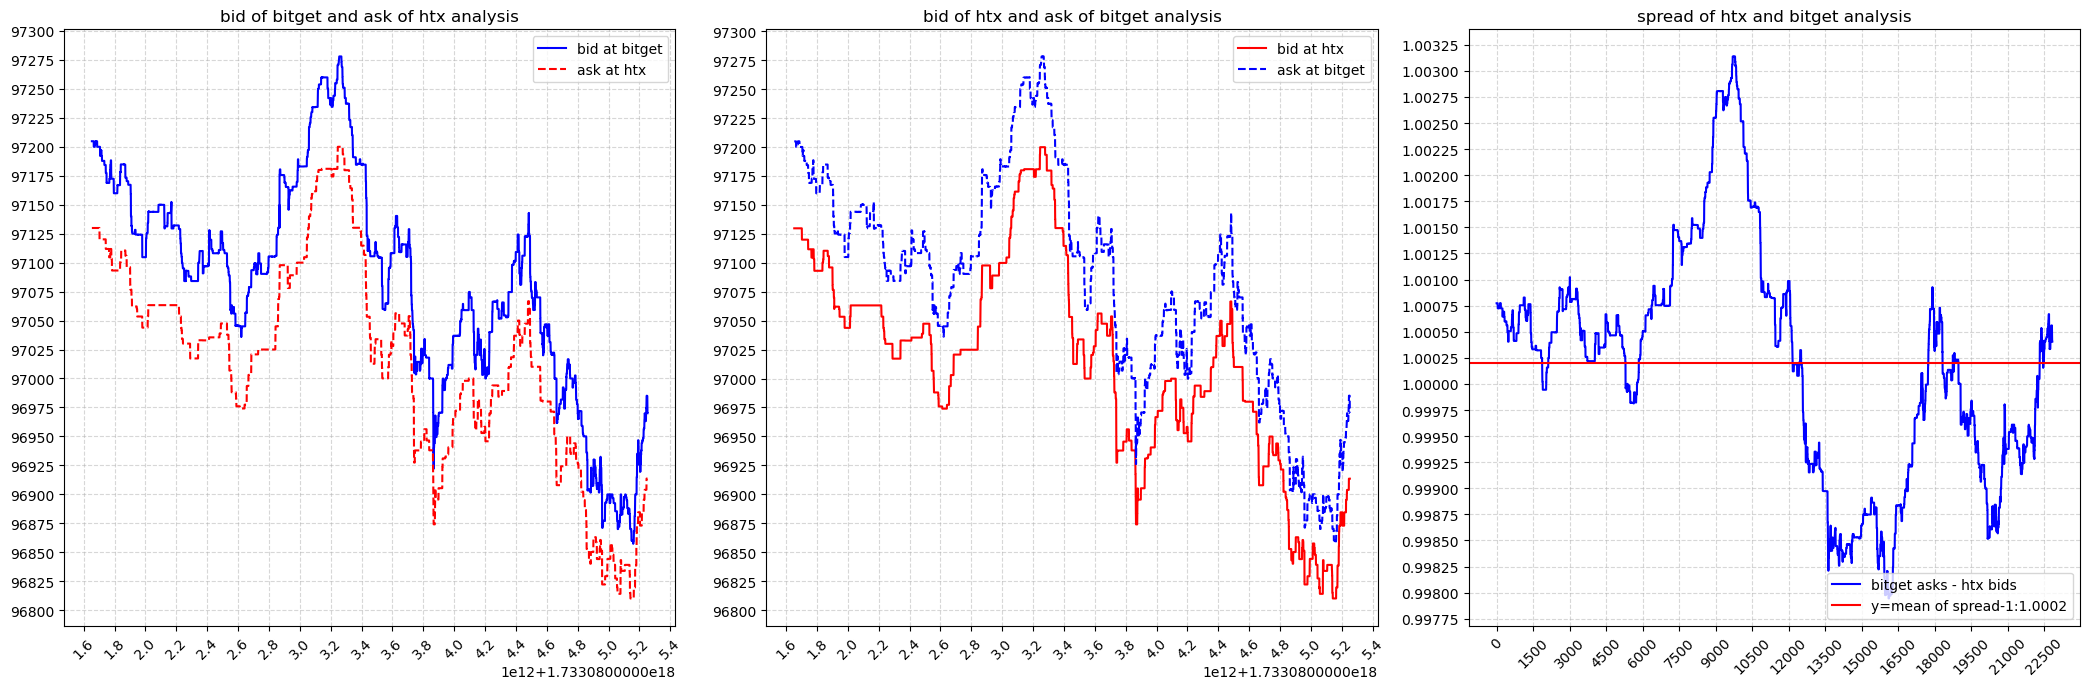

bitget gateio
22832


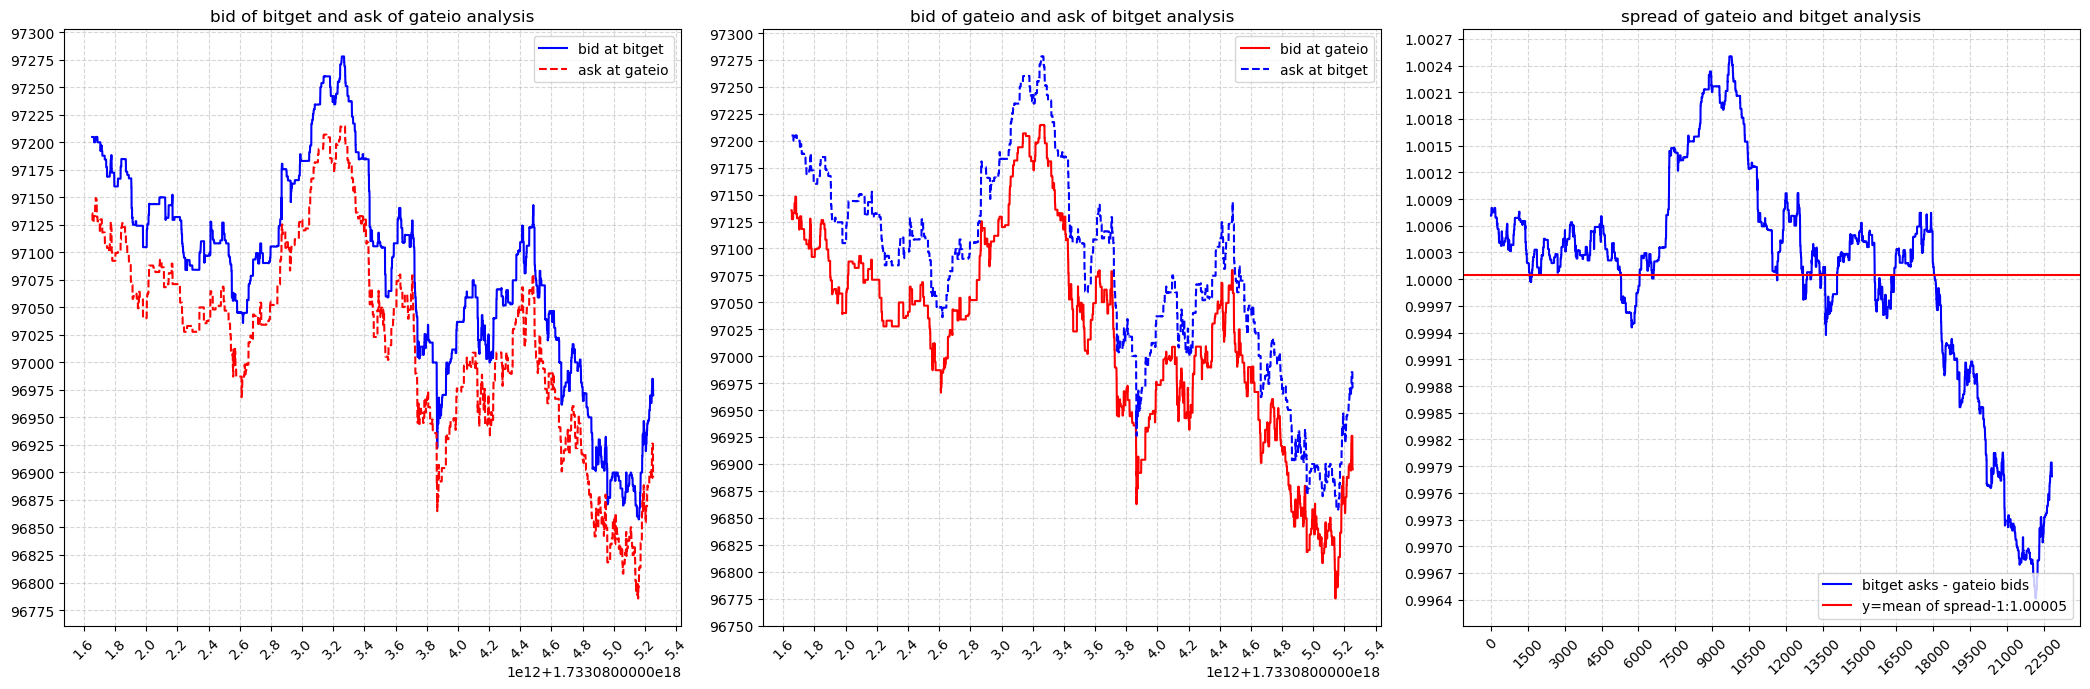

bitget bybit
22832


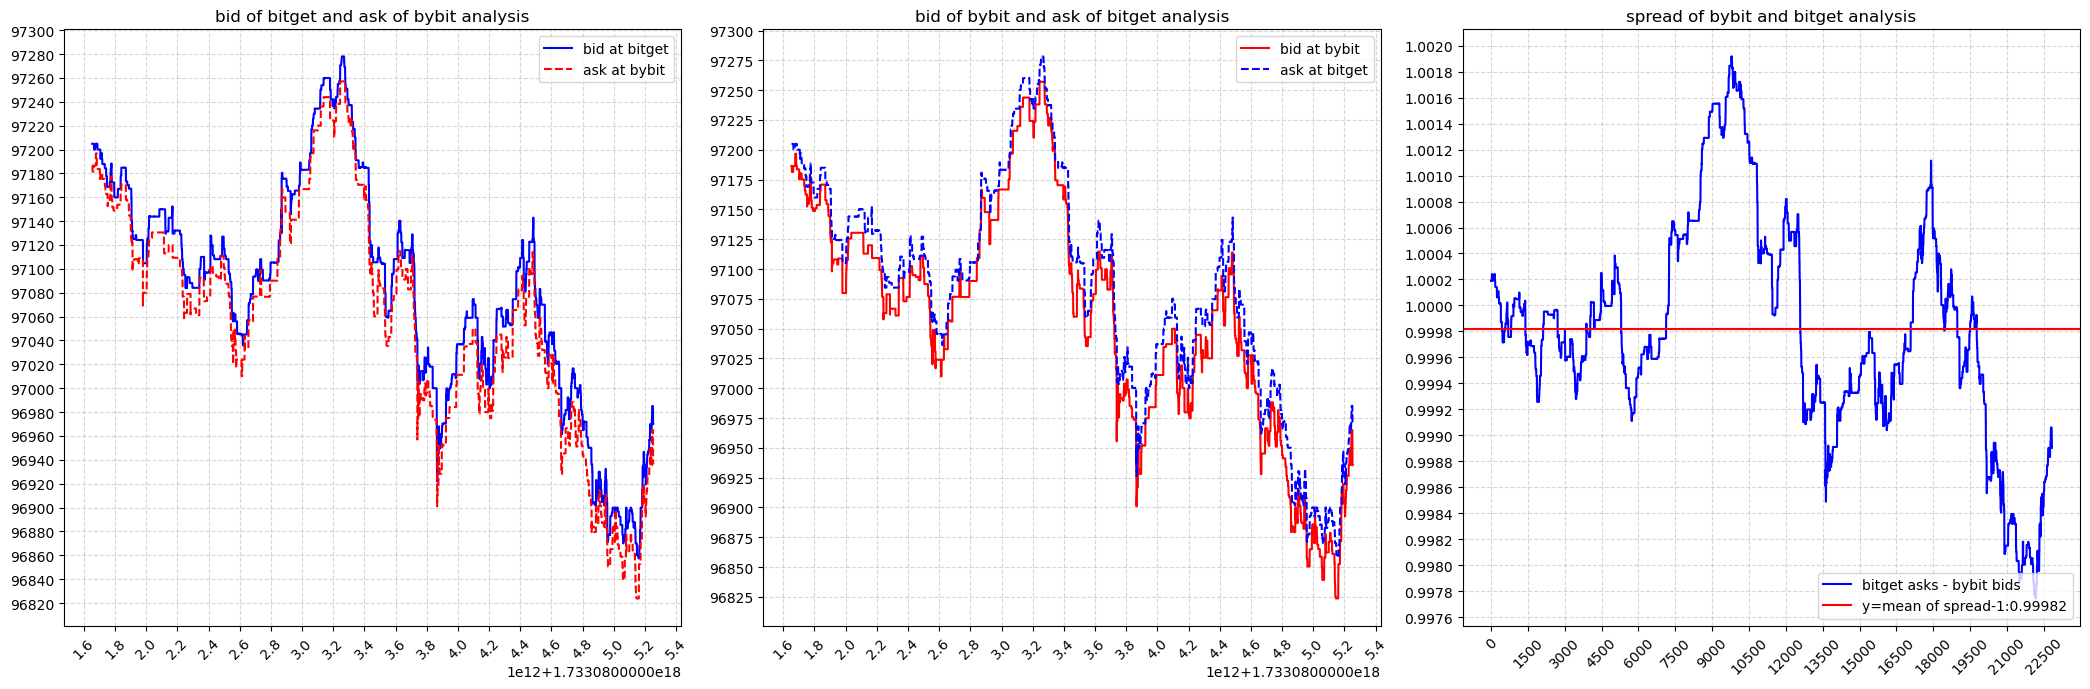

htx gateio
35998


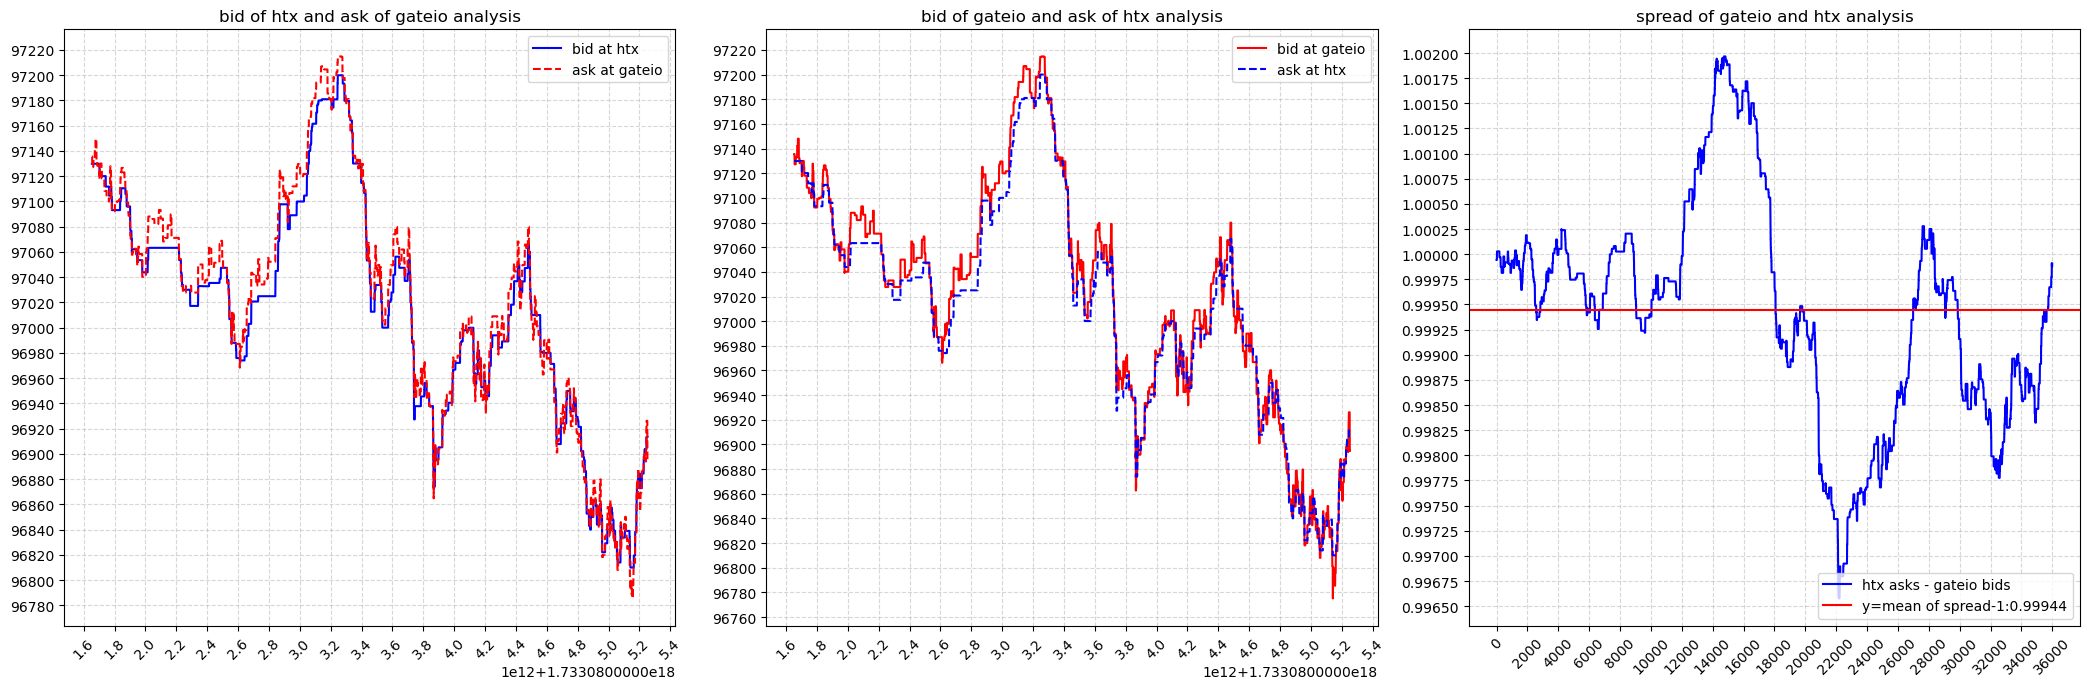

htx bybit
35998


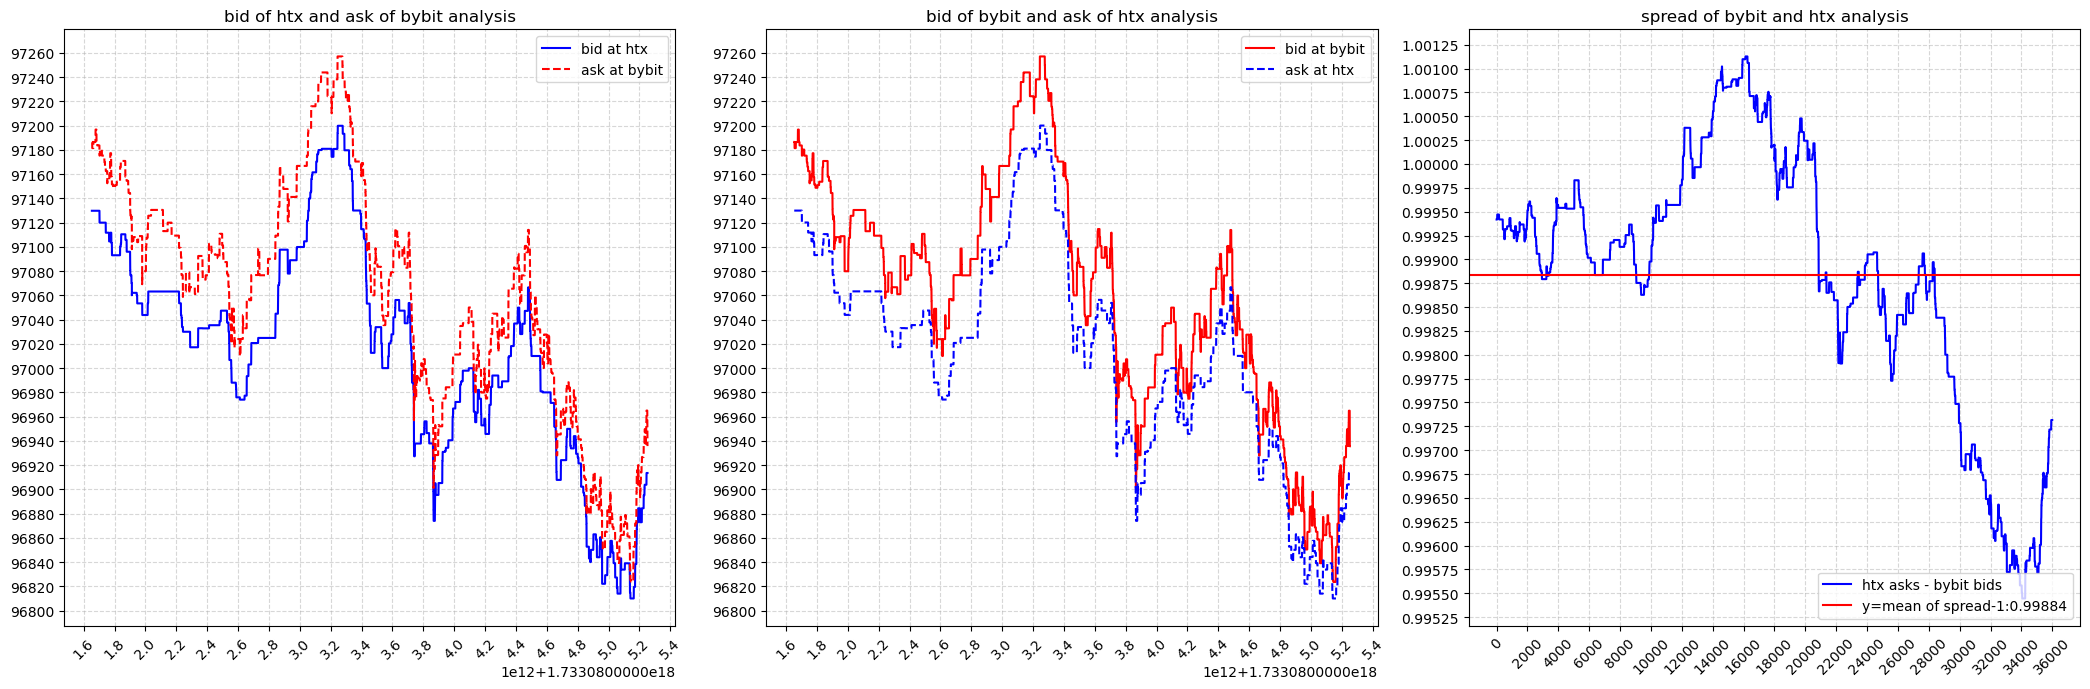

gateio bybit
62793


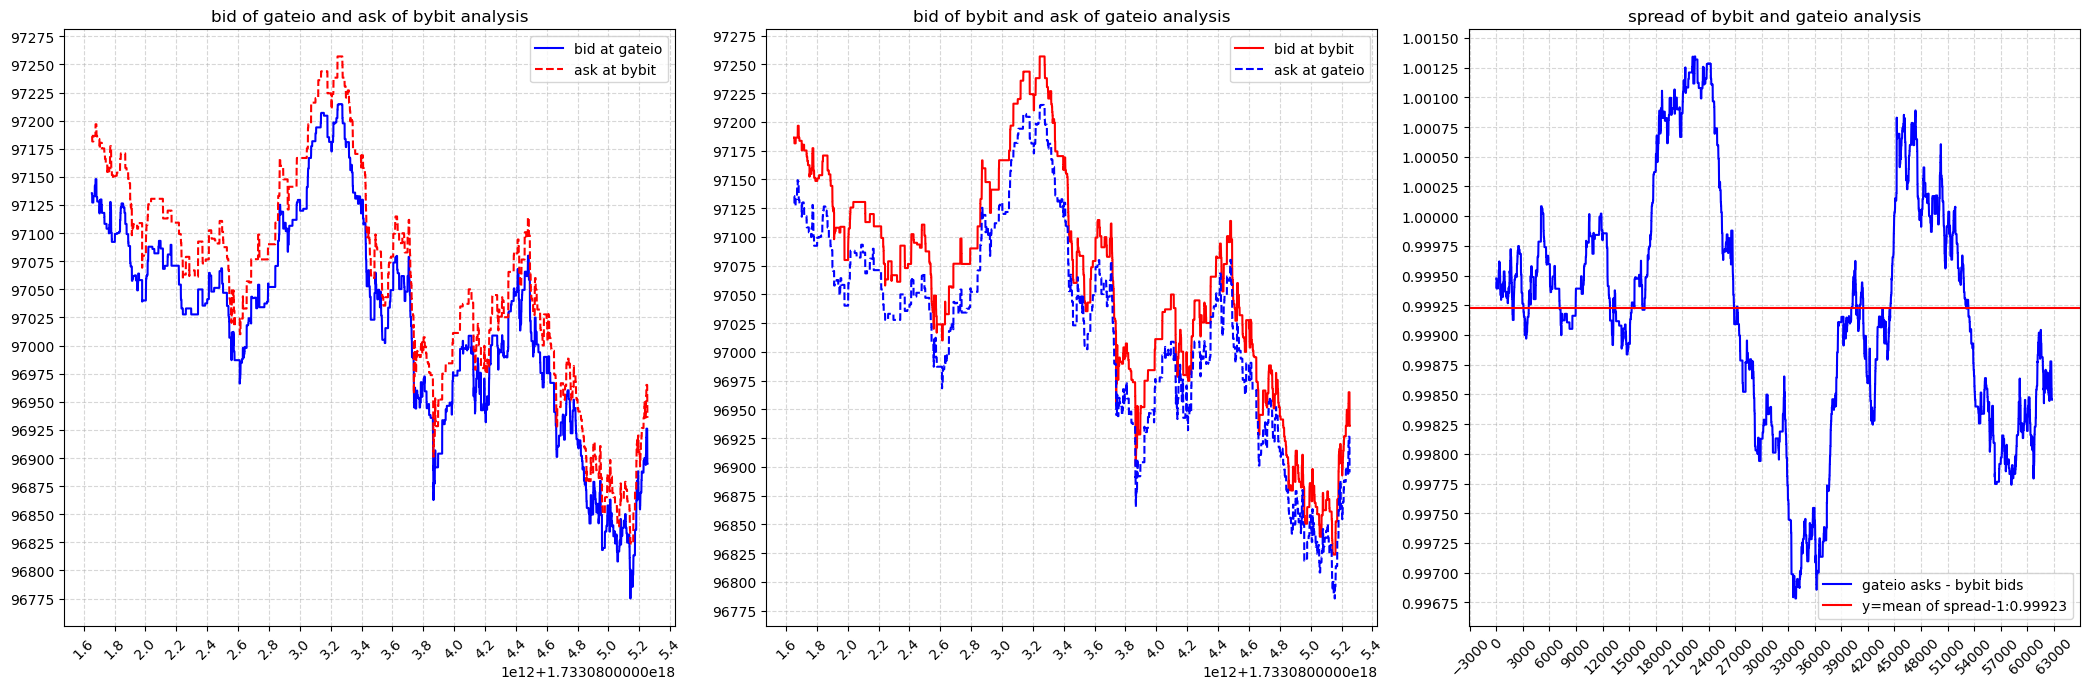

In [47]:
# plot 
for i in range(4):
    combinatio = []
    for j in range(i+1, 4):
        curr_set = (i, j)
        print(ids[i], ids[j])
        
        df = dfs[i]
        df2 = dfs[j]

        # Create subplots
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))  # 1 row, 2 columns

        # First subplot
        ax1.plot(df["bids"], label= f"bid at {ids[i]}", linestyle='-', color='blue')
        ax1.plot(df2["asks"], label= f"ask at {ids[j]}", linestyle='--', color='red')
        ax1.set_title(f"bid of {ids[i]} and ask of {ids[j]} analysis")
        ax1.legend()
        ax1.xaxis.set_major_locator(MaxNLocator(25))  # Show up to 10 x-ticks
        ax1.yaxis.set_major_locator(MaxNLocator(25))  # Show up to 10 y-ticks
        ax1.tick_params(axis='x', rotation=45) 

        # Second subplot
        ax2.plot(df2["bids"], label= f"bid at {ids[j]}", linestyle='-', color='red')
        ax2.plot(df["asks"], label= f"ask at {ids[i]}", linestyle='--', color='blue')
        ax2.set_title(f"bid of {ids[j]} and ask of {ids[i]} analysis")
        ax2.legend()
        ax2.xaxis.set_major_locator(MaxNLocator(25))  # Show up to 10 x-ticks
        ax2.yaxis.set_major_locator(MaxNLocator(25))  # Show up to 10 y-ticks
        ax2.tick_params(axis='x', rotation=45) 

        # plot spread
        spread_len = min(df.shape[0], df2.shape[0])
        print(spread_len)
        spread1 = df.iloc[ : spread_len, 1].to_numpy() / df2.iloc[ : spread_len, 0].to_numpy()
        spread2 = df2.iloc[ : spread_len, 1].to_numpy() / df.iloc[ : spread_len, 0].to_numpy()
        
        
        # third sublot
        ax3.plot(spread1, label= f"{ids[i]} asks - {ids[j]} bids", linestyle='-', color='blue')
        #ax3.plot(spread2, label= f"{ids[j]} asks - {ids[i]} bids", linestyle='--', color='green')
        # Plot a horizontal line at y=0
        mean1 = round(spread1.mean(), 5)
        #mean2 = round(spread2.mean(), 5)
        ax3.axhline(y=mean1, color="red", linestyle="-", label=f"y=mean of spread-1:{mean1}")
        #3ax3.axhline(y=mean2, color="red", linestyle="-", label=f"y= mean of spread-2:{mean2}")

        ax3.set_title(f"spread of {ids[j]} and {ids[i]} analysis")
        ax3.legend(loc="lower right")
        ax3.xaxis.set_major_locator(MaxNLocator(25))  # Show up to 10 x-ticks
        ax3.yaxis.set_major_locator(MaxNLocator(25))  # Show up to 10 y-ticks
        ax3.tick_params(axis='x', rotation=45) 

        ax1.grid(True, linestyle="--", alpha=0.5)
        ax2.grid(True, linestyle="--", alpha=0.5)
        ax3.grid(True, linestyle="--", alpha=0.5)
        
        
        # plt.plot(df["bids"], label= f"bid at {ids[i]}", linestyle='-', color='blue')
        # plt.plot(df["asks"], label= f"ask at {ids[j]}", linestyle='--', color='red')
        # plt.plot(df2["bids"], label= f"bid at {ids[i]}", linestyle='-', color='green')
        # plt.plot(df2["asks"], label= f"ask at {ids[j]}", linestyle='--', color='black')
        # plt.xticks(rotation=45)
        # plt.legend()
        # plt.title(f"{ids[i]} and {ids[j]}")
        # plt.gca().xaxis.set_major_locator(MaxNLocator(25))  # Show up to 10 x-ticks
        # plt.gca().yaxis.set_major_locator(MaxNLocator(25))  # Show up to 10 y-ticks

        # Show the figure
        plt.tight_layout()
        plt.show()